# Advection-diffusion problem

In this task, we'll simulate advection-diffusion in a fluid domain.

Natively, advection is not taken into account in FESTIM. The idea is therefore to modify the governing equations by adding an advection term.

In [1]:
import festim as F

my_model = F.Simulation()

Create a mesh with FEniCS and mark the subdomains.

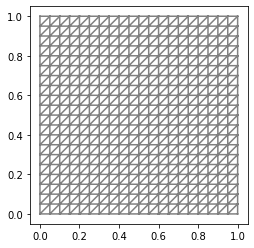

In [2]:
from fenics import UnitSquareMesh, CompiledSubDomain, MeshFunction, plot

# creating a mesh with FEniCS
nx = ny = 20
mesh_fenics = UnitSquareMesh(nx, ny)


# marking physical groups (volumes and surfaces)
volume_markers = MeshFunction("size_t", mesh_fenics, mesh_fenics.topology().dim())
volume_markers.set_all(1)

tol = 1e-14

left_surface = CompiledSubDomain('on_boundary && near(x[0], 0, tol)',
                                tol=tol)
right_surface = CompiledSubDomain('on_boundary && near(x[0], 1, tol)',
                                     tol=tol)
bottom_surface = CompiledSubDomain('on_boundary && near(x[1], 0, tol)',
                                     tol=tol)
top_surface = CompiledSubDomain('on_boundary && near(x[1], 1, tol)',
                                     tol=tol)

surface_markers = MeshFunction("size_t", mesh_fenics, mesh_fenics.topology().dim() - 1)
surface_markers.set_all(0)

left_id = 1
top_and_bottom_id = 2
right_id = 3
left_surface.mark(surface_markers, left_id)
right_surface.mark(surface_markers, right_id)
top_surface.mark(surface_markers, top_and_bottom_id)
bottom_surface.mark(surface_markers, top_and_bottom_id)

plot(mesh_fenics)

The mesh can now be passed to a `festim.Mesh` object.

In [3]:
# creating mesh with FESTIM
my_model.mesh = F.Mesh(
    mesh=mesh_fenics,
    volume_markers=volume_markers,
    surface_markers=surface_markers
)

Let's add the rest of the parameters.
For this case, the concentration will be set to 1 on the left surface and to zero on the top and bottom surfaces.

In [4]:
my_model.materials = F.Material(id=1, D_0=1, E_D=0)

my_model.T = F.Temperature(500)

my_model.boundary_conditions = [
    F.DirichletBC(surfaces=top_and_bottom_id, value=0),
    F.DirichletBC(surfaces=left_id, value=1)
    ]

my_model.settings = F.Settings(
    absolute_tolerance=1e-10,
    relative_tolerance=1e-10,
    transient=False
    )

We can now run the pure diffusion simulation and visualise the hydrogen concentration field.

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


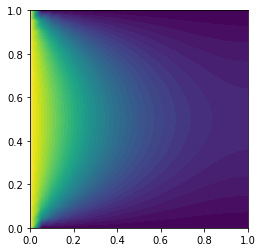

In [5]:
my_model.initialise()
my_model.run()


hydrogen_concentration = my_model.h_transport_problem.mobile.solution

plot(hydrogen_concentration)

## Adding advection

Let's now add an advection term. To do so, we first need to create a velocity field.
For simplicity sake, we will create an arbitrary field `velocity`.

> 
> Note: this velocity field can be obtained from solving the Navier-Stokes equations with FEniCS or with another code (OpenFOAM).
> 

In [6]:
from fenics import interpolate, Expression, VectorFunctionSpace

functionspace = VectorFunctionSpace(my_model.mesh.mesh, "CG", 1)

velocity = Expression(("-100*x[1]*(x[1] - 1)", "0"), degree=2)

velocity = interpolate(velocity, functionspace)

Here's what `velocity` looks like:

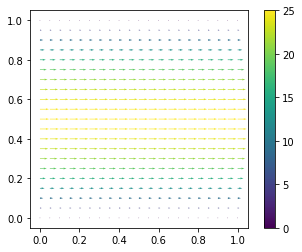

In [11]:
import matplotlib.pyplot as plt

CS = plot(velocity)
plt.colorbar(CS)
plt.show()

Now that we created a FEniCS function representing the velocity, let's add an advection term.

The governing equation needs to be:

$$\nabla \cdot (D \nabla c) - v \cdot \nabla c = 0$$

where $D$ is the diffusion coefficient, $c$ is the hydrogen concentration and $v$ is the velocity.

To modify the governing equations, one needs to modify the formulation of the H transport problem.
It can be accessed in `my_model.h_transport_problem.F`.

See [this FEniCS tutorial](https://fenicsproject.org/pub/tutorial/html/._ftut1010.html) for more information on finite element formulations.

In [8]:
from fenics import inner, dot, grad

my_model.initialise() # reinitialisation is needed

hydrogen_concentration = my_model.h_transport_problem.mobile.solution
test_function_solute = my_model.h_transport_problem.mobile.test_function

advection_term = inner(dot(grad(hydrogen_concentration), velocity), test_function_solute) * my_model.mesh.dx

my_model.h_transport_problem.F += advection_term

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions


Now that the governing equation has been modified, let's run the simulation again and check the new concentration field.

Solving steady state problem...
Solved problem in 0.00 s


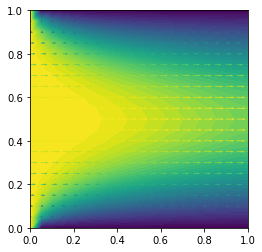

In [9]:
my_model.run()
plot(hydrogen_concentration)
plot(velocity)
plt.show()

The concentration field is greatly affected as particles are now pushed towards the right hand side of the domain!